# Visualize the best RFE conformations using cMDS plots

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import *
from helper_modules.MDS import *

### Load protein related data

In [2]:
prot_name = 'egfr'

In [3]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_EGFR_175_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)
df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1m14,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",0,[],None,NaN
1m17,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",1,[AQ4],AQ4,370.253100
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1,A,2.4,0.936,19.256,5,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2,"[FMM, PO4]",FMM,554.851103


### Load the dimensionality reduction results

In [4]:
df_dims = pd.read_pickle('../3_Protein_Ensembles_Analysis/df_PROTEINS_DIMS_reduced_TABLE.obj')

# Update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y
1m14,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",0,[],None,NaN,0.151076,-0.035884,0.858278,0.031719,0.771499,0.045323
1m17,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.6,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",1,[AQ4],AQ4,370.253100,0.187558,-0.035292,0.773396,-0.103687,0.755275,0.014972
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1,A,2.4,0.936,19.256,5,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2,"[FMM, PO4]",FMM,554.851103,-0.403078,0.043509,-1.348996,-0.088785,-1.247659,0.160348


### Load POVME3 results and single-conformation docking performances (AUC-ROC)

In [5]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'../4_Ensemble_docking_results/TABLE_Confs_Features_and_performances_egfr.pkl')

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']

# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

# Dataframe with all conformations
print('Original Dataframe shape:', df_prot.shape)

# ********* Only for EGFR and HSP90 *********
# Keep only the randomly chosen conformations
np.random.seed(42) # Use the seed for reproducibility
pdb_ids_selected = np.sort(np.random.choice(df_prot.index, 64, replace = False))
df_prot = df_prot.loc[pdb_ids_selected]
print('Final Dataframe shape:', df_prot.shape)

Original Dataframe shape: (175, 23)
Final Dataframe shape: (64, 23)


### Load *Recursive Feature Elimination* results

In [6]:
# Open RFE_estimator
# Open RFE_estimator
dataset    = 'MERGED'
model_name = 'XGB_tree'
split      = 'random'
filename   = f'./cachedir/rfe_selectors/RFE_xgb_{prot_name}.joblib'
# Load the RFE selector (computed in the previos notebook)
rfe_selector = joblib.load(filename)
# Create a dataframe with the protein rankings
df_ranks     = pd.DataFrame({
                     'pdb_id'     : df_prot.index, 
                     'rfe_ranking': rfe_selector.ranking_
               })
df_ranks     = df_ranks.sort_values('rfe_ranking').set_index('pdb_id')

# Update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y,volume,surf_area,AUC-ROC,rfe_ranking
2itx,structures of lung cancer-derived egfr mutants...,2007-04-03,1,A,2.98,0.984,20.661,3,"[696, 4, 260]","[[1, 696], [862, 865], [951, 1210]]",...,0.215914,-0.011661,0.953309,-0.019725,0.852202,0.127104,1169.0,686.0,0.81903,1
2itz,structures of lung cancer-derived egfr mutants...,2007-04-03,1,A,2.80,0.961,20.165,3,"[696, 10, 260]","[[1, 696], [866, 875], [951, 1210]]",...,0.169669,-0.040096,0.770728,-0.247422,0.707170,0.200122,1097.0,690.0,0.80687,2
3w2r,structure-based approach for the discovery of ...,2013-01-16,1,A,2.05,0.945,19.752,3,"[697, 14, 260]","[[1, 697], [862, 875], [951, 1210]]",...,-0.160169,-0.141299,-1.145035,0.074368,-0.838134,-0.269677,931.0,831.0,0.46026,3


## cMDS plots
We will use `ggplot2` for plotting

In [7]:
%load_ext rpy2.ipython

Just a few modifications for visualization purposes.

In [8]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume.T'] = (df_prot['volume']/100) ** 1.5

df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'vol_x'
y = 'vol_y'
size='volume.T'

#### Create the dataframe for plotting

In [9]:
# This is the final table for plotting
df_volpk = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]
df_volpk = df_volpk.rename({'vol_x': 'x', 'vol_y': 'y'}, axis = 1)
df_volpk

,rfe_ranking,x,y,volume
2itx,1,0.215914,-0.011661,1169.0
2itz,2,0.169669,-0.040096,1097.0
3w2r,3,-0.160169,-0.141299,931.0
5gtz,4,0.168317,0.017898,1288.0
6jwl,5,0.124305,0.071267,1262.0
...,...,...,...,...
2itq,60,0.196540,-0.036809,1133.0
6s9c,61,0.112976,-0.132151,838.0
6jz0,62,0.203230,-0.031545,1169.0
6jrj,63,0.085602,0.152532,1364.0


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



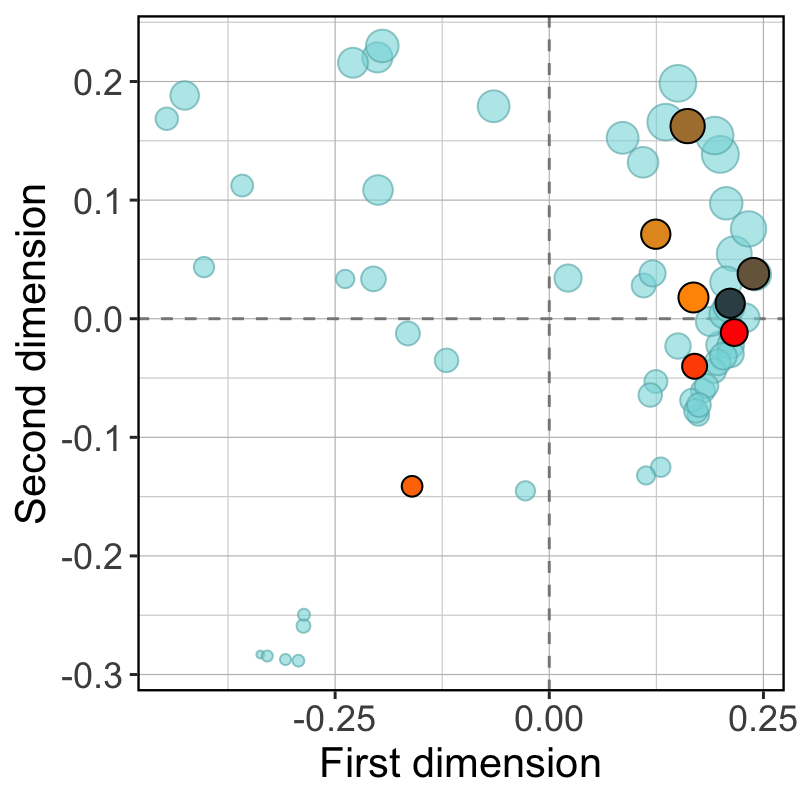

In [10]:
%%R -i df_volpk -i prot_name -w 4. -h 4. --units in -r 200

source('../../R_scripts/plot_cMDS.R')
prot_name <- prot_name

p <- plot_cMDS(df_volpk)

# Save the picture
space <- 'povme'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4., height= 4.) 
print(p)

## Swarplot with the AUC-ROC values per conformation
- The following plot show the distribution of the protein conformations regarding its AUC-ROC value computed from their individual docking results.

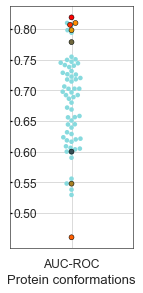

In [11]:
import matplotlib
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

top_confs = 8

# Define the colormap
cmap = LinearSegmentedColormap.from_list(
    name ='test', 
    colors = ["red", "orange", "#374E55"],
    N = top_confs
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale = 1.1, style = 'whitegrid')

# Filter the 
df_ = df_prot.copy()
# Get the top 16
df_['top_mask'] = [2 if i <= top_confs else 
                   1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']]\
                    .melt(id_vars=('top_mask', 
                                   'rfe_ranking'))

fig, ax = plt.subplots(figsize=(2.2, 4.45))
# Blue dots (all conformations)
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_, 
              size = 4.6,
              ax = ax,
              color = '#87DADE')
# Plot the top RFE 16 conformations
df_top = df_.query('top_mask == 2') 
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_top, 
              size = 5,
              ax  = ax,
              hue ='rfe_ranking',
              edgecolor = 'black', 
              linewidth = 0.5,
              palette = 'mycolormap')
# Axis and labels
ax.set_yticks(np.arange(0.5, 0.80, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length = 2, color = 'black', axis = 'y')
ax.grid(True, linewidth = 0.7)
ax.tick_params(axis="y",direction="in", pad=-27)
ax.set(xlabel = 'Protein conformations', ylabel = '')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.savefig(f'{prot_name}_swarm_auc.pdf')

# Save the picture
plt.show()

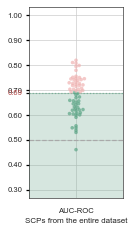

In [12]:
top_confs = 8

# Define the colormap
cmap = LinearSegmentedColormap.from_list(
    name ='test', 
    colors = ["red", "orange", "#374E55"],
    N = top_confs
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale = 0.7, style = 'whitegrid')

# Filter the 
df_ = df_prot.copy()
# Get the top 16
df_['top_mask'] = [2 if i <= top_confs else 
                   1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']]\
                    .melt(id_vars=('top_mask', 
                                   'rfe_ranking'))
# Get the AUC-ROC of the 32 lowest conformation
auc_worst_32 = df_['value'].nsmallest(32).max()
df_['worst_32'] = df_['value'] <= auc_worst_32

fig, ax = plt.subplots(figsize=(1.7, 3.52))
# Blue dots (all conformations)
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_, 
              size = 3.6,
              ax = ax,
              alpha = 0.7,
              hue = 'worst_32',
              palette = ['#F0B3B2', '#5CA586'])
# Axis and labels
ax.set_yticks(list(np.arange(0.3, 1.1, .1)) + [auc_worst_32])
ax.get_yticklabels()[-1].set_color("#B24745")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
plt.axhline(y=0.5, color='darkgrey', linewidth = 1.2, linestyle = '--')
plt.axhline(y=auc_worst_32, color='#79AF97', 
            linestyle=':', linewidth = 1.2)
ax.fill_between([-1,1], [0], [auc_worst_32], color='#79AF97', alpha = 0.3 )
ax.tick_params(length = 3, color = 'black', axis = 'y')
ax.grid(True, linewidth = 0.7)
# ax.tick_params(axis="y",direction="in", pad=-27)
ax.set_xlabel('SCPs from the entire dataset', fontsize = 8)
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.ylim(0.265, 1.033)
plt.savefig(f'{prot_name}_swarm_auc.pdf')
# Save the picture
plt.show()

## MDS using Secondary structure 
- The following projection was computed from the pairwise RMSD matrix of the C$\alpha$ of the residues belonging to the protein's secondary structure.

In [13]:
df_secRMSD = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]
df_secRMSD = df_secRMSD.rename({'secres_x': 'x', 'secres_y': 'y'}, axis = 1)

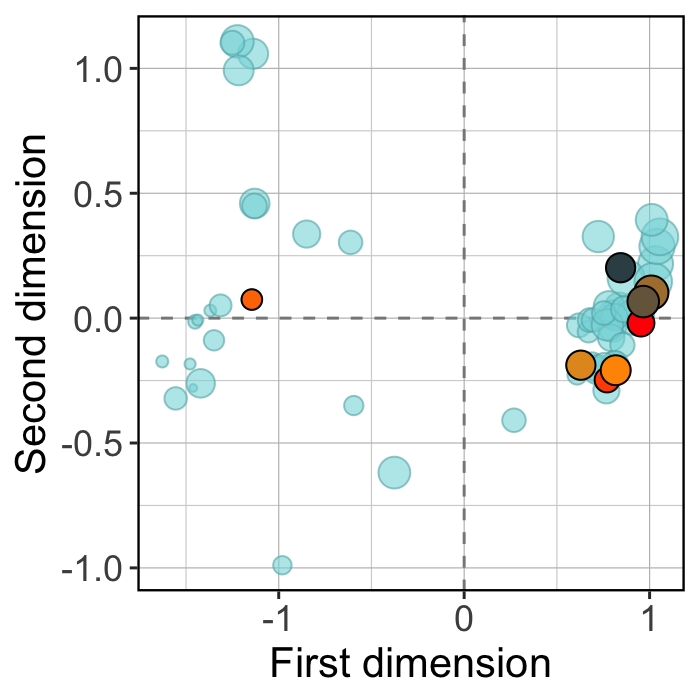

In [14]:
%%R -i df_secRMSD -w 3.5 -h 3.5 --units in -r 200

p <- plot_cMDS(df_secRMSD, top_ = 8)

# Save the picture
space <- 'secRMSD'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4.0, height= 4.0) 
print(p)

## MDS using pocket residues

In [15]:
df_pkRMSD = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]
df_pkRMSD = df_pkRMSD.rename({'pkt_x': 'x', 'pkt_y': 'y'}, axis = 1)

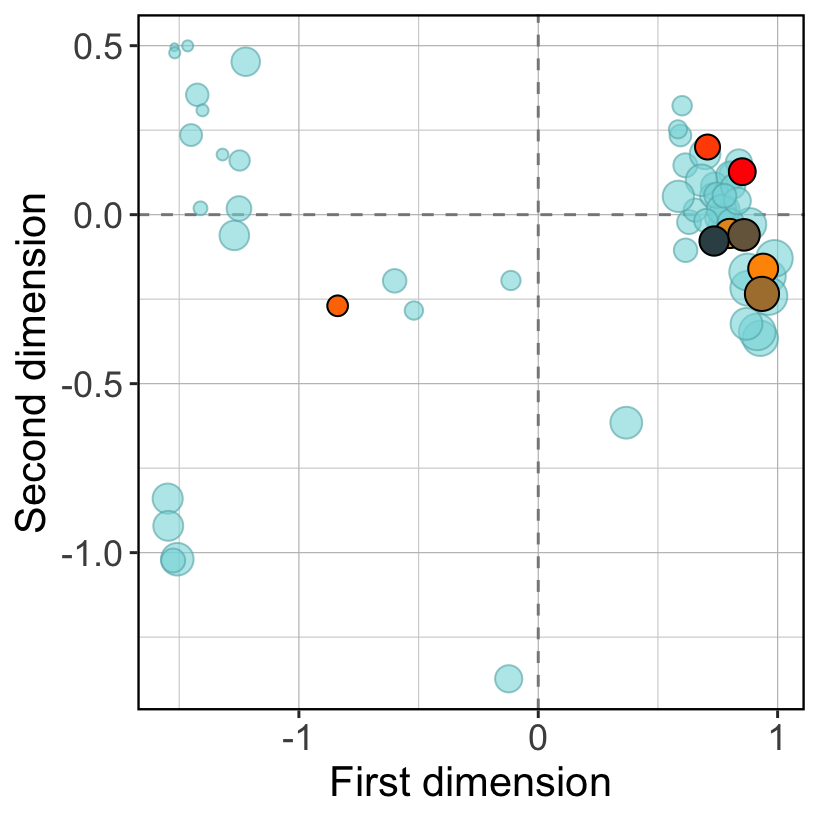

In [16]:
%%R -i df_pkRMSD -w 4.1 -h 4.1 --units in -r 200

p <- plot_cMDS(df_pkRMSD, top_ = 8)

# Save the picture
space <- 'pkRMSD'
methodology <- 'MDS_plots/'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, methodology,
                   paste(prot_name, space, 'MDS.pdf', sep='_'))
ggsave(filename, plot=p, width=4.0, height= 4.0) 
print(p)